In [ ]:
import torch
import os
from train import id_to_string
from metrics import word_error_rate, sentence_acc
from checkpoint import load_checkpoint
from torchvision import transforms
from dataset import LoadEvalDataset, collate_eval_batch, START, PAD
from flags import Flags
from utils import get_network, get_optimizer
import csv
from torch.utils.data import DataLoader
import argparse
import random
from tqdm import tqdm

In [ ]:
import numpy as np
import pandas as pd
import pdb

# DataFrame 생성

In [ ]:
# dataframe 생성
def create_df(default_image_path:str, gt_path:str):
    data = dict()
    data['name'] = []
    data['latex_str'] = []
    data['latex'] = []
    data['invisible_braket_cnt'] = []
    all_latex_list = []
    with open(gt_path) as f:
        for idx,line in enumerate(f):
            image_name, latex=line.replace("\n","").split("\t")
            data['name'].append(image_name)
            data['latex_str'].append(latex) # 추가 4
            latex=latex.split(" ")
            cnt = 0
            for ch in latex:
                if ch in ['\left.', '\right.']:
                    cnt += 1
            data['invisible_braket_cnt'].append(cnt)
            data['latex'].append(latex)
            all_latex_list += latex
    df = pd.DataFrame.from_dict(data)
    return df, all_latex_list

In [ ]:
df, all_latex_list = create_df(
    default_image_path="/opt/ml/input/data/train_dataset/images/",
    gt_path="/opt/ml/input/data/train_dataset/gt.txt",
)

In [ ]:
df

In [ ]:
df[df['invisible_braket_cnt'] > 0]

# 모델

In [ ]:
from dataset import dataset_loader, START, PAD,load_vocab

In [ ]:
################################# paresr 부분 대체하는 코드 ########################
# 이후 parser에 접근 하는 코드 모두 알맞게 수정
cfg = dict()
# 1. 학습된 모델 체크포인트
cfg['checkpoint'] = '/opt/ml/code/log/satrn7/checkpoints/0060.pth'
# 2. EDA에 사용할 데이터
cfg['file_path'] = '/opt/ml/input/data/train_dataset/gt.txt'
# 3. 사용할 데이터 범위 (train_dataset 십만개 기준, 한번에 하면 에러가 나서.)
cfg['start'] = 0
cfg['end'] = 100
# 4. 기타
cfg['max_sequence'] = 230
cfg['batch_size'] = 32
cfg['log_dir'] = '/opt/ml/code/eda/'
####################################################################################

# 1. 체크포인트 로드
is_cuda = torch.cuda.is_available()
checkpoint = load_checkpoint(cfg['checkpoint'], cuda=is_cuda) #checkpoint = load_checkpoint(parser.checkpoint, cuda=is_cuda)

# 2. 체크포인트로부터 옵션 로드 & seed pix
options = Flags(checkpoint["configs"]).get()
torch.manual_seed(options.seed)
random.seed(options.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

hardware = "cuda" if is_cuda else "cpu"
device = torch.device(hardware)
print("--------------------------------")
print("Running {} on device {}\n".format(options.network, device))

model_checkpoint = checkpoint["model"]
if model_checkpoint:
    print(
        "[+] Checkpoint\n",
        "Resuming from epoch : {}\n".format(checkpoint["epoch"]),
    )
print(options.input_size.height)

##################################################################
dummy_gt = "\sin " * cfg['max_sequence']  # set maximum inference sequence
root = os.path.join(os.path.dirname(cfg['file_path']), "images")
# data = []
test_data = []
gt = []
with open(cfg['file_path'], "r") as fd:
    reader = csv.reader(fd, delimiter="\t")
    for i, x in enumerate(reader):
        if i < cfg['start']:
            continue
        if i >= cfg['end']:
            break
        test_data.append([os.path.join(root, x[0]), x[0], dummy_gt])
        gt.append(x[1])
#################################################################
transformed = transforms.Compose(
        [
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ]
    )
print('size',options.input_size.height, options.input_size.width)
test_dataset = LoadEvalDataset(
    test_data,
    checkpoint["token_to_id"],
    checkpoint["id_to_token"],
    crop=False,
    transform=transformed,
    rgb=options.data.rgb
)
test_data_loader = DataLoader(
    test_dataset,
    batch_size=cfg['batch_size'],
    shuffle=False,
    num_workers=options.num_workers,
    collate_fn=collate_eval_batch,
)

print("[+] Data\n",
      "The number of test samples : {}\n".format(len(test_dataset)),)

model = get_network(
    options.network,
    options,
    model_checkpoint,
    device,
    test_dataset,
)
model.eval()
print(
    "[+] Network\n",
    "Type: {}\n".format(options.network),
)

In [ ]:
def save_checkpoint(checkpoint, dir="./checkpoints", prefix=""):
    # Padded to 4 digits because of lexical sorting of numbers.
    # e.g. 0009.pth
    filename = "{num:0>4}.pth".format(num=checkpoint["epoch"])
    if not os.path.exists(os.path.join(prefix, dir)):
        os.makedirs(os.path.join(prefix, dir))
    
torch.save(checkpoint, os.path.join(prefix, dir, filename))

In [ ]:
def dict_to_namedtuple(d):
    """ Convert dictionary to named tuple.
    """
    FLAGSTuple = collections.namedtuple('FLAGS', sorted(d.keys()))

    for k, v in d.items():
        
        if k == 'prefix':
            v = os.path.join('./', v)

        if type(v) is dict:
            d[k] = dict_to_namedtuple(v)

        elif type(v) is str:
            try:
                d[k] = eval(v)
            except:
                d[k] = v

    nt = FLAGSTuple(**d)

    return nt

In [ ]:
import collections

In [ ]:
class Flags:
    """ Flags object.
    """

    def __init__(self, config_file):
        try:
            with open(config_file, 'r') as f:
                d = yaml.safe_load(f)
        except:
            d = config_file


        self.flags = dict_to_namedtuple(d)

    def get(self):
        return self.flags

In [ ]:
temp=Flags({'height':64, 'width':256})

In [ ]:
temp

In [ ]:
temp

In [ ]:
type(checkpoint)

In [ ]:
checkpoint.keys()

In [ ]:
checkpoint['configs']['input_size']

In [ ]:
checkpoint['configs']['input_size'

In [ ]:
checkpoint['configs']

In [ ]:
options.input_size.height = 64

In [ ]:
# default_image_path="/opt/ml/input/data/train_dataset/images/"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def origin_img(img_path):
    img = mpimg.imread(img_path)
    plt.grid(True, color='w')
    plt.imshow(img)
    plt.show()
    return 

In [ ]:
def cal_invisible_braket(gt, pred):
    cnt1, cnt2 = 0, 0
    for token in gt.split():
        if token in ['\left.', '\right.']:
            cnt1 += 1
    for token in pred.split():
        if token in ['\left.', '\right.']:
            cnt2 += 1
    return cnt1, cnt2

In [ ]:
results = [] # file_name, pred, gt, invisible_cnt(gt's, pred's)
i = 0
for d in tqdm(test_data_loader):
    input = d["image"].to(device)
    expected = d["truth"]["encoded"].to(device) # dummy_gt
    output = model(input, expected, False, 0.0)
    decoded_values = output.transpose(1, 2)
    _, sequence = torch.topk(decoded_values, 1, dim=1)
    sequence = sequence.squeeze(1)
    sequence_str = id_to_string(sequence, test_data_loader, do_eval=1)
    for name, predicted in zip(d["file_path"], sequence_str):
        results.append((name, predicted, gt[i], cal_invisible_braket(gt[i], predicted)))
        i += 1

In [ ]:
with open(os.path.join(cfg['log_dir'], "total_eda2.csv"), "a") as a:
    for name, pred, gt, invisible_cnt in results:
        a.write(name + "\t" + pred + "\t" + gt + "\t" + str(invisible_cnt[0]) + "\t" + str(invisible_cnt[0]-invisible_cnt[1]) + '\n')
        if pred.strip() != gt.strip():
#             print(name + "\t" + pred + "\t" + gt + "\t" + str(invisible_cnt[0]) + "\t" + str(invisible_cnt[0]-invisible_cnt[1]) + '\n')
            origin_img('/opt/ml/input/data/train_dataset/images/'+name)
            print(f'name: {name}')
            print(f'gt: {gt}')
            print(f'pd: {pred}')
#             print(f'{invisible_cnt}')

In [14]:
input = d["image"].to(device)

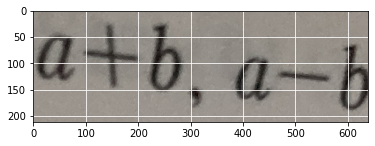

In [21]:
origin_img('/opt/ml/input/data/train_dataset/images/' + d["file_path"][0])

In [87]:
sample_path = '/opt/ml/input/data/train_dataset/images/' + d["file_path"][1]

In [59]:
from PIL import Image, ImageOps
img = Image.open(sample_path)

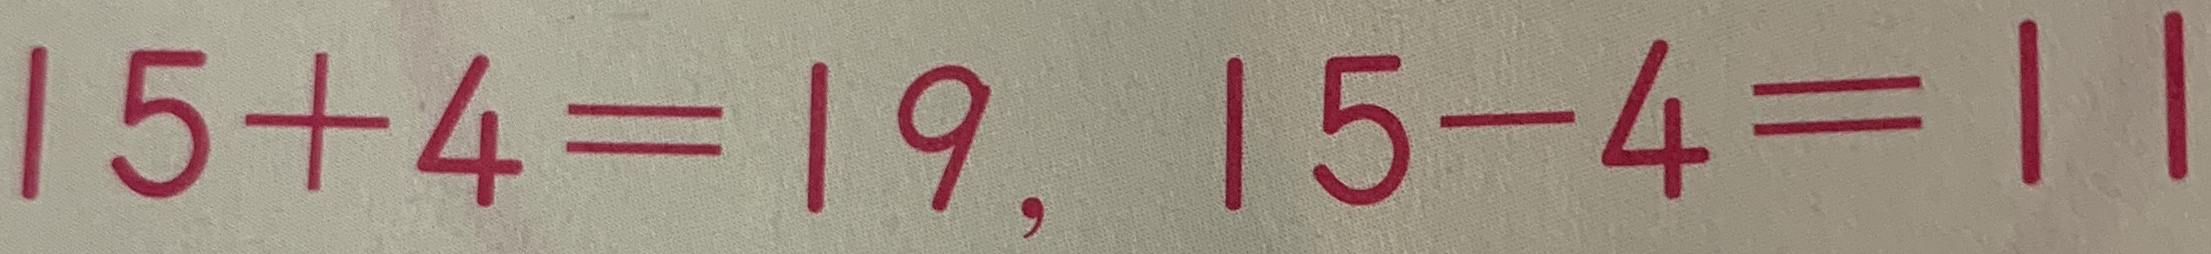

In [60]:
img

In [61]:
img.size

(2211, 254)

In [62]:
converted = img.convert("L")

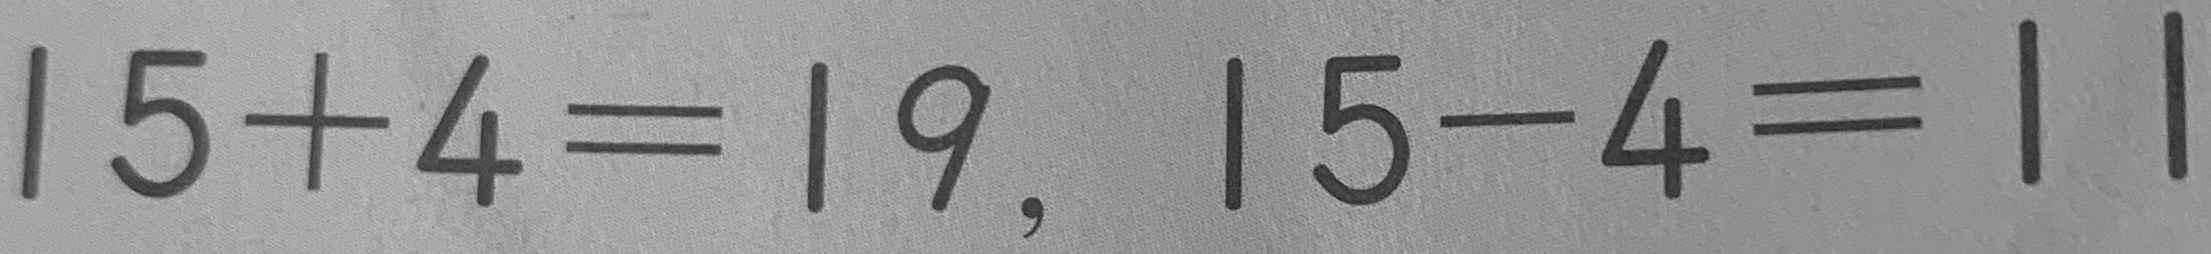

In [63]:
converted

In [64]:
converted.size

(2211, 254)

In [65]:
bounding_box = ImageOps.invert(converted).getbbox()

In [66]:
bounding_box

(0, 0, 2211, 254)

In [67]:
croped = converted.crop(bounding_box)

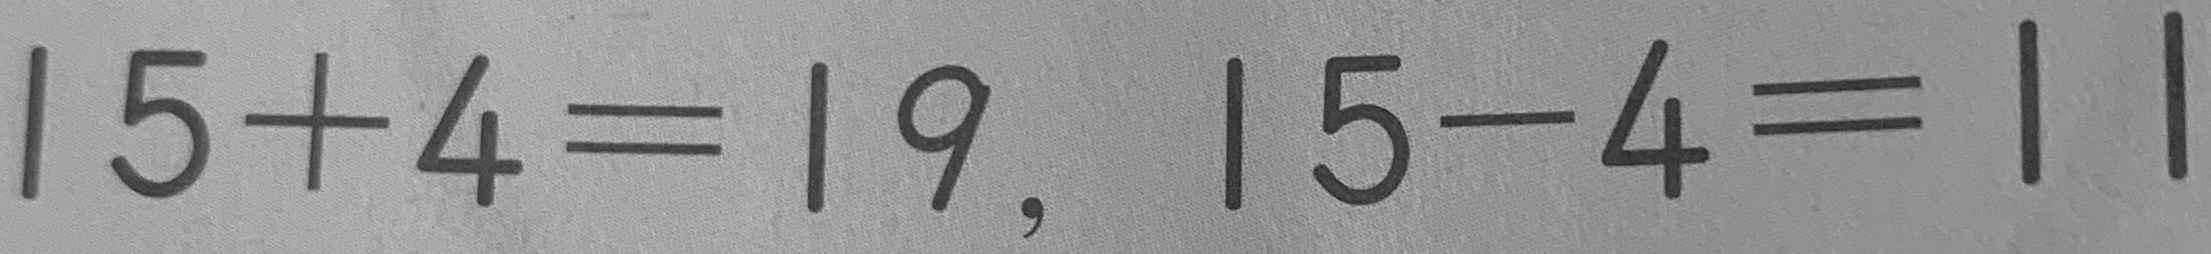

In [93]:
croped

In [94]:
croped.size

(2211, 254)

In [72]:
import albumentations as A

In [76]:
transform = A.Compose([
    A.Resize(128, 128)
])

In [79]:
np_array = np.array(croped)

In [89]:
resized = transform(image=np_array)['image']

In [95]:
resized

array([[160, 160, 172, ..., 140, 150, 148],
       [161, 162, 163, ..., 140, 148, 145],
       [159, 160, 177, ..., 146, 146, 147],
       ...,
       [158, 164, 162, ..., 147, 153, 151],
       [169, 164, 163, ..., 150, 148, 149],
       [165, 163, 163, ..., 151, 148, 145]], dtype=uint8)

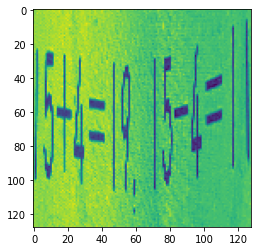

In [96]:
plt.imshow(resized)
plt.show()

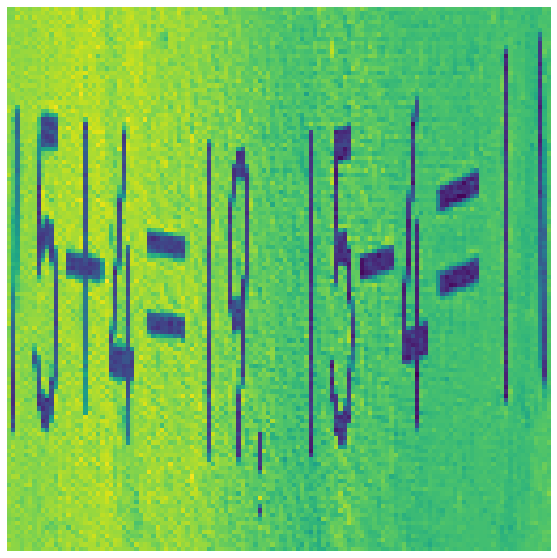

In [91]:
visualize(resized)

In [83]:
import cv2
from matplotlib import pyplot as plt

import albumentations as A

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

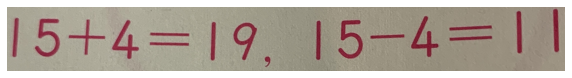

In [88]:
image2 = cv2.imread(sample_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
visualize(image2)

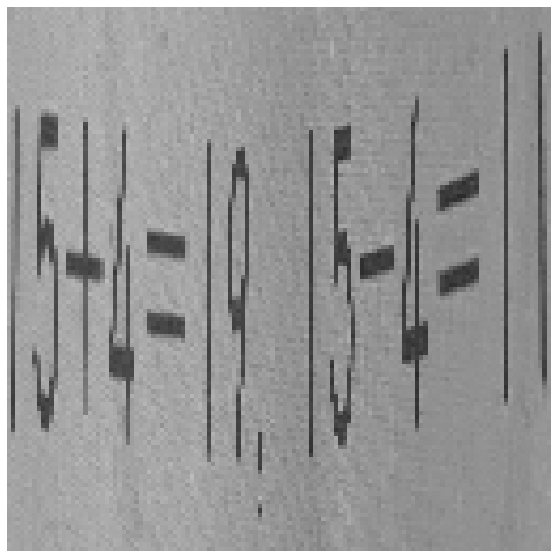

In [105]:
augmented_image = A.Compose([
    A.Resize(128, 128),
    A.ToGray()
])(image=image2)['image']
visualize(augmented_image)

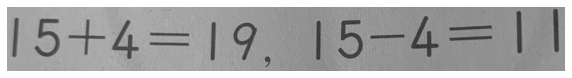

In [103]:
gray_image = A.ToGray()(image=image2)['image']
visualize(gray_image)

In [39]:
aaa

array([[[147, 143, 134],
        [148, 144, 135],
        [147, 143, 134],
        ...,
        [163, 154, 147],
        [158, 149, 142],
        [157, 148, 141]],

       [[150, 146, 137],
        [146, 142, 133],
        [152, 148, 139],
        ...,
        [159, 150, 143],
        [154, 145, 138],
        [154, 145, 138]],

       [[153, 149, 140],
        [148, 144, 135],
        [151, 147, 138],
        ...,
        [162, 153, 146],
        [157, 148, 141],
        [157, 148, 141]],

       ...,

       [[155, 148, 140],
        [156, 149, 141],
        [158, 151, 143],
        ...,
        [165, 158, 152],
        [168, 161, 155],
        [165, 158, 152]],

       [[154, 147, 139],
        [156, 149, 141],
        [157, 150, 142],
        ...,
        [154, 147, 141],
        [157, 150, 144],
        [157, 150, 144]],

       [[154, 147, 139],
        [156, 149, 141],
        [156, 149, 141],
        ...,
        [153, 146, 140],
        [154, 147, 141],
        [153, 146, 140]]

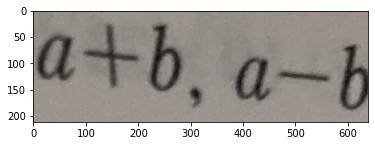

In [38]:
plt.imshow(aaa)

In [23]:
img1 = mpimg.imread('/opt/ml/input/data/train_dataset/images/' + d["file_path"][0])
img1

array([[[147, 143, 134],
        [148, 144, 135],
        [147, 143, 134],
        ...,
        [163, 154, 147],
        [158, 149, 142],
        [157, 148, 141]],

       [[150, 146, 137],
        [146, 142, 133],
        [152, 148, 139],
        ...,
        [159, 150, 143],
        [154, 145, 138],
        [154, 145, 138]],

       [[153, 149, 140],
        [148, 144, 135],
        [151, 147, 138],
        ...,
        [162, 153, 146],
        [157, 148, 141],
        [157, 148, 141]],

       ...,

       [[155, 148, 140],
        [156, 149, 141],
        [158, 151, 143],
        ...,
        [165, 158, 152],
        [168, 161, 155],
        [165, 158, 152]],

       [[154, 147, 139],
        [156, 149, 141],
        [157, 150, 142],
        ...,
        [154, 147, 141],
        [157, 150, 144],
        [157, 150, 144]],

       [[154, 147, 139],
        [156, 149, 141],
        [156, 149, 141],
        ...,
        [153, 146, 140],
        [154, 147, 141],
        [153, 146, 140]]

In [33]:
from PIL import Image
img = Image.open('/opt/ml/input/data/train_dataset/images/' + d["file_path"][0])

In [35]:
img

In [28]:
img.show()

In [17]:
# rgb
img2 = img1.convert("L")

AttributeError: 'NoneType' object has no attribute 'convert'